In [1]:
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data preparations

Displaying the sample images from each class

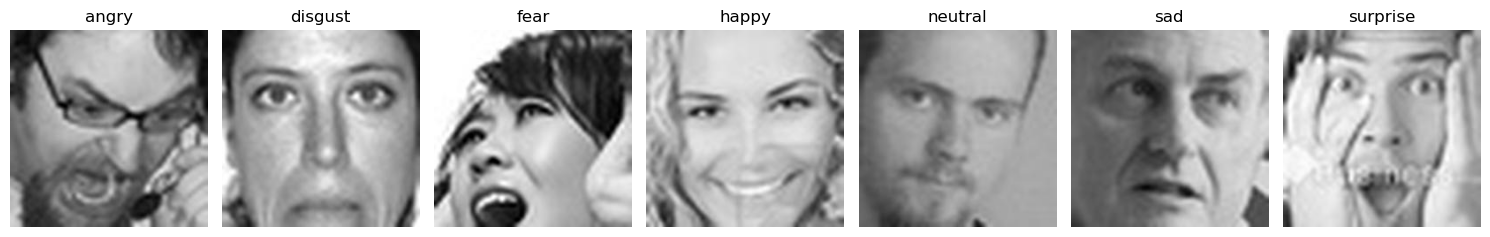

In [3]:
def display_sample_images(data_folder):
    class_folders = sorted(os.listdir(data_folder))
    fig, axes = plt.subplots(1, len(class_folders), figsize=(15, 5))
    
    for ax, class_name in zip(axes, class_folders):
        class_path = os.path.join(data_folder, class_name)
        if os.path.isdir(class_path):
            sample_image = next((f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))), None)
            if sample_image:
                img_path = os.path.join(class_path, sample_image)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
                ax.set_title(class_name)
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images('data')

Extracting dimensions of the images

In [4]:
def print_image_dimensions(data_dir):
    class_dimensions = {}
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_path):
            dimensions = {}
            
            for file in os.listdir(class_path):
                if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):
                    file_path = os.path.join(class_path, file)
                    
                    with Image.open(file_path) as img:
                        width, height = img.size
                        dim = (width, height)
                        dimensions[dim] = dimensions.get(dim, 0) + 1
            
            class_dimensions[class_name] = dimensions
    
    for class_name, dims in class_dimensions.items():
        print(f"Class: {class_name}")
        for dim, count in dims.items():
            print(f"  Dimension: {dim[0]}x{dim[1]}, Count: {count}")

print_image_dimensions('data')

Class: angry
  Dimension: 224x224, Count: 4953
Class: disgust
  Dimension: 224x224, Count: 547
Class: fear
  Dimension: 224x224, Count: 5121
Class: happy
  Dimension: 224x224, Count: 8989
Class: neutral
  Dimension: 224x224, Count: 6198
Class: sad
  Dimension: 224x224, Count: 6077
Class: surprise
  Dimension: 224x224, Count: 4002


Calculating total number of images in each class

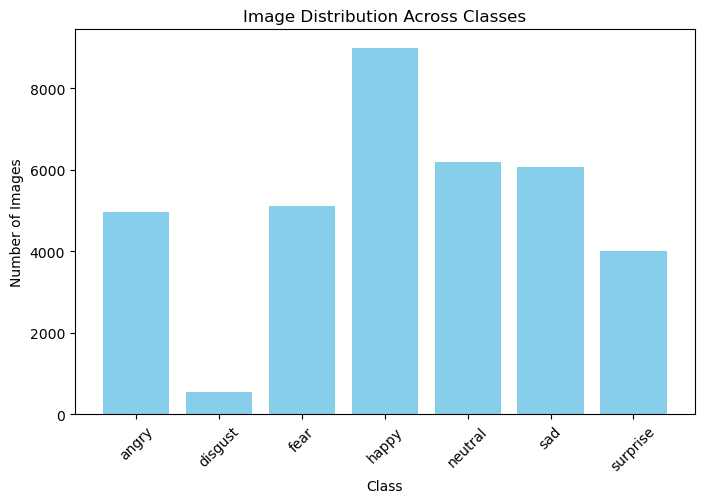

In [5]:
def count_images_in_classes(data_dir):
    class_counts = {}
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_path):
            image_count = sum(1 for file in os.listdir(class_path) 
                              if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')))
            class_counts[class_name] = image_count
    
    return class_counts

def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(8, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Image Distribution Across Classes')
    plt.xticks(rotation=45)
    plt.show()

class_counts = count_images_in_classes('data')
plot_class_distribution(class_counts)

Spliting the data into train (70%), test(15%) and validation(15%) sets

In [6]:
def split_data(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_path):
            images = [file for file in os.listdir(class_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
            random.shuffle(images)
            
            train_split = int(len(images) * train_ratio)
            val_split = int(len(images) * (train_ratio + val_ratio))
            
            splits = {
                'train': images[:train_split],
                'val': images[train_split:val_split],
                'test': images[val_split:]
            }
            
            for split, files in splits.items():
                split_class_dir = os.path.join(output_dir, split, class_name)
                os.makedirs(split_class_dir, exist_ok=True)
                
                for file in files:
                    shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))
    
    print('Dataset successfully split into train, val, and test sets.')

split_data('data', 'split')

Dataset successfully split into train, val, and test sets.


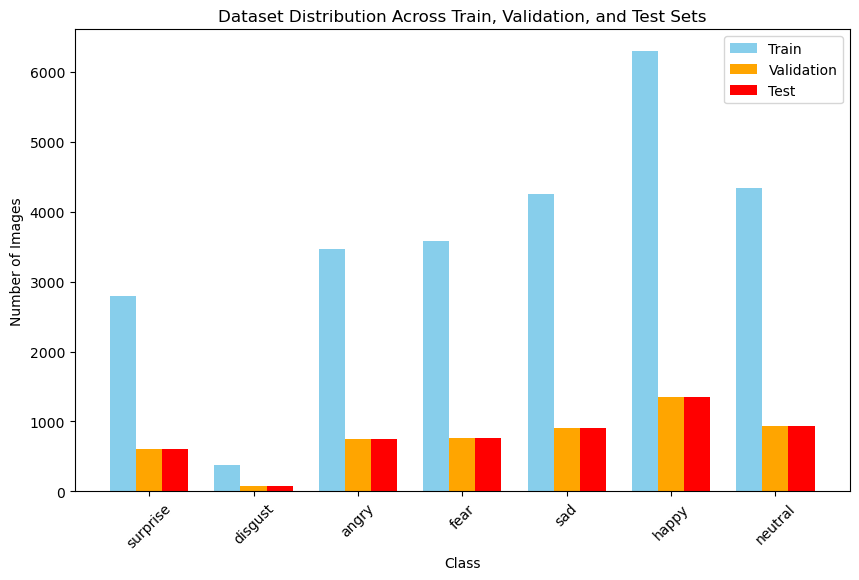

In [7]:
def plot_dataset_distribution(output_dir):
    splits = ['train', 'val', 'test']
    class_counts = {split: {} for split in splits}
    
    for split in splits:
        split_path = os.path.join(output_dir, split)
        
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                class_counts[split][class_name] = len(os.listdir(class_path))
    
    classes = list(set().union(*[class_counts[split].keys() for split in splits]))
    
    train_counts = [class_counts['train'].get(cls, 0) for cls in classes]
    val_counts = [class_counts['val'].get(cls, 0) for cls in classes]
    test_counts = [class_counts['test'].get(cls, 0) for cls in classes]
    
    x = np.arange(len(classes))
    width = 0.25
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width, train_counts, width, label='Train', color='skyblue')
    plt.bar(x, val_counts, width, label='Validation', color='orange')
    plt.bar(x + width, test_counts, width, label='Test', color='red')
    
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Dataset Distribution Across Train, Validation, and Test Sets')
    plt.xticks(ticks=x, labels=classes, rotation=45)
    plt.legend()
    plt.show()

plot_dataset_distribution('split')

## Custom CNN model training

In [8]:
data_dir = "split"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [9]:
# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Dataset loading successful!")

Dataset loading successful!


In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [11]:
model = CNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        end_time = time.time()
        print(f"Epoch {epoch+1}/{epochs}, Time: {end_time - start_time:.2f}s")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%\n")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Time: 425.94s
Train Loss: 1.8212, Train Acc: 24.49%
Val Loss: 1.7750, Val Acc: 25.32%

Epoch 2/50, Time: 416.07s
Train Loss: 1.7834, Train Acc: 25.95%
Val Loss: 1.7522, Val Acc: 28.53%

Epoch 3/50, Time: 414.36s
Train Loss: 1.7589, Train Acc: 27.75%
Val Loss: 1.6648, Val Acc: 33.10%

Epoch 4/50, Time: 211.94s
Train Loss: 1.7394, Train Acc: 29.17%
Val Loss: 1.6306, Val Acc: 33.49%

Epoch 5/50, Time: 90.81s
Train Loss: 1.7068, Train Acc: 30.78%
Val Loss: 1.5760, Val Acc: 38.34%

Epoch 6/50, Time: 92.57s
Train Loss: 1.6766, Train Acc: 32.84%
Val Loss: 1.5496, Val Acc: 40.50%

Epoch 7/50, Time: 86.22s
Train Loss: 1.6592, Train Acc: 33.75%
Val Loss: 1.5293, Val Acc: 39.88%

Epoch 8/50, Time: 86.51s
Train Loss: 1.6373, Train Acc: 34.71%
Val Loss: 1.4958, Val Acc: 41.35%

Epoch 9/50, Time: 83.03s
Train Loss: 1.6221, Train Acc: 36.05%
Val Loss: 1.4405, Val Acc: 43.99%

Epoch 10/50, Time: 92.53s
Train Loss: 1.6064, Train Acc: 36.33%
Val Loss: 1.4419, Val Acc: 44.94%

Epoch 11/50, Ti

([1.8211531519130537,
  1.7833692448913672,
  1.758926618934437,
  1.7393852715279645,
  1.7067888777726774,
  1.6765604119391957,
  1.6592370444801963,
  1.6372993071367785,
  1.62210067487826,
  1.6063886961359886,
  1.591935967791612,
  1.5806989680429933,
  1.5629089808008474,
  1.5567646234658115,
  1.5539825772024265,
  1.554127916257093,
  1.5403767865174895,
  1.5333871777649897,
  1.52406870164689,
  1.5248533063633427,
  1.518367310238492,
  1.512371549484836,
  1.5089968690446987,
  1.5053771813204333,
  1.4935493731195,
  1.4942289086663798,
  1.4831199260274317,
  1.4858060300729836,
  1.4817164115845018,
  1.486142574450013,
  1.47981047934028,
  1.4788284002595646,
  1.4788353242691914,
  1.4718306957536442,
  1.4691297778658048,
  1.4667002661212993,
  1.4683293861948001,
  1.4598434796758517,
  1.4610886816765851,
  1.460472655827832,
  1.46164408398282,
  1.4585242684479731,
  1.4547797452871967,
  1.4555560067201117,
  1.4595720534112044,
  1.4516778336968392,
  1.44

In [13]:
# Test the model
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate on test data
test_model(model, test_loader)

Test Accuracy: 50.49%


In [14]:
torch.save(model, "cnn.pth")